# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) Exercise ReID

In this exercise, we investigate appearance-based tracking by training a ReID network that we apply on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is

- to implement Hungarian matching in the tracker.
- to train a small ReID dataset with cross-entropy and triplet-loss.
- to apply the trained ReID network on the detected MOT16 bounding boxes.


## Setup

### Download and extract project data to your Google Drive

1.   **Required**: Please follow all instructions of exercise 0 before running this notebook.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/webermar/cv3dst_reid_exercise.zip) zip file to your desktop, extract it and upload it into the `Colab Notebooks` folder in your Google Drive.

#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


We're unzipping the dataset to the colab disk.

In [2]:
!unzip "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/market/bounding_box_train/0685_c6s2_054993_03.jpg  
  inflating: data/market/bounding_box_train/0486_c5s1_146945_06.jpg  
  inflating: data/market/bounding_box_train/0259_c3s1_054501_01.jpg  
  inflating: data/market/bounding_box_train/1421_c2s3_046707_01.jpg  
  inflating: data/market/bounding_box_train/0255_c6s1_054401_01.jpg  
  inflating: data/market/bounding_box_train/0132_c3s1_021801_01.jpg  
  inflating: data/market/bounding_box_train/0204_c1s1_041176_01.jpg  
  inflating: data/market/bounding_box_train/0324_c4s2_001342_01.jpg  
  inflating: data/market/bounding_box_train/0414_c5s1_098248_03.jpg  
  inflating: data/market/bounding_box_train/0100_c1s5_014111_01.jpg  
  inflating: data/market/bounding_box_train/0052_c2s1_005101_01.jpg  
  inflating: data/market/bounding_box_train/0100_c3s2_149244_01.jpg  
  inflating: data/market/bounding_box_train/0104_c6s1_018126_01.jpg  
  inflating: data/market/bounding_box_t

In [3]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/"
reid_root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/"

The `root_dir` path points to the directory and the content in your Google Drive.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/src/market"

data.zip  params.pth	  save_mode_resnet34.pth  src
output	  save_model.pth  save.pth
datamanager.py	__init__.py  models.py	  sampler.py	 utils.py
dataset.py	metrics.py   __pycache__  transforms.py


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(reid_root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5 MB 7.7 MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590193 sha256=9b19bd1010d0203a5ef3fde4331dc9448c483869fb214a7603cf0e961f7e5bb4
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built lap
     \ 148 kB 4.3 MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-py3-none-any.whl size=134199 sha256=d75f89bdd1a10f93ed532585fd84caf4fbb4eefd32fd38c1544cb141638a7d51
  Stored in directory: /tmp/pip-ephem-wheel-cache-8lpimz2q/wheels/39/60/bf/90b1b02ff42db1bf7f2d2fa3eef2fe8bc46061182cf4ce7b37
Successfully built motmetrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker, ReIDTracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

from scipy.optimize import linear_sum_assignment as linear_assignment

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'MOT16-02'`, or the entire train/test set, e.g., `seq_name = 'MOT16-train'`.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-06  MOT16-07	MOT16-08  MOT16-12  MOT16-14


## Example sequences

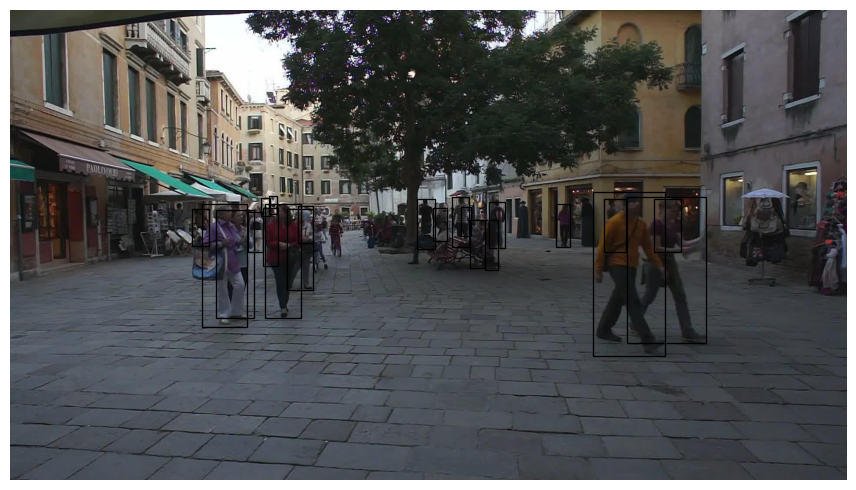

In [ ]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True) # Get a coffee.

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set for this exercise.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [6]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3 # lambda, threshold for judging if two boxes are overlapping

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device) # 转到GPU上

FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

In [8]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

# evaluate_obj_detect(obj_detect, data_loader_test)

# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

## Configuration

In [43]:
seed = 12345
seq_name = 'MOT16-reid'  # We recommend to use this subset.
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')
print(output_dir)

gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output


## Setup

In [44]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

In [45]:
# Old Tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks: # tracks mean detections
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0) # along axis0 concatenate n boxes`matrix。get matrix with shape (n,box.length[0],box.length[1])
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5) # calculate IoU distance. diatance is a N*K matrix, n is num. of objectbox, k is num. of Hypothesis rectangles
            # track_boxes : Nx4 array Object rectangles (x,y,w,h) in rows;   boxes : Kx4 array Hypothesis rectangles (x,y,w,h) in rows
            # print("distance",distance.shape)   # distance (15, 16)
            # print("boxes",boxes.numpy().shape)  # boxes (16, 4)
            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance): # group the as a turple
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist) # choose a nearest(mini IoU distance) Hypothesis rectangle for a specific object reactangle
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids] # not in remove track lists, preserve

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])    # if a Hypothesis rectangle is far away from any Object rectangles, it means, it is a new box, maybe a new object.
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)

## Exercise Part I - Hungarian IoU Tracker

The previous tracker `TrackerIoUAssignment` will build a cost matrix as follows: Given $n$ tracks and $m$ detected boxes, the result will be a $n\times m$ matrix with each being $1 - IoU(track, box)$ for $IoU >= 0.5$ and `np.nan` otherwise. Then, each track is extended with the best box in terms of costs. All predicted boxes, that don't overlap, i.e., $IoU < 0.5$, at all with the tracks start new tracks.

This Tracker has several issues. Can you spot them?

$Answer:$ 1. There would be possibly muti-matchting using this tracker. 2. max_iou is a hyperparameter, and both narrow and wide threshold would bring some problems, i.e. low precison or low recall. 

One, of the issues is that this tracker does not ensure unique matching. Therefore, your task is to implement a tracker that uses hungarian matching. In the following, we provide a code fragment that you can use.

In [46]:
_UNMATCHED_COST = 255.0
class HungarianIoUTracker(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks: # if track is not None
            #print("self.tracks",self.tracks)
            track_ids = [t.id for t in self.tracks]
            #print("track_ids",track_ids)
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            # Build cost matrix.
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)
            # print(boxes.numpy)

            # Set all unmatched costs to _UNMATCHED_COST.
            distance = np.where(np.isnan(distance), _UNMATCHED_COST, distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance) # 这就是两个一维数组，长度相等，一一对应。row_idx[i] and col_idx[i] define a match
            #print("row_idx", row_idx)
            #print("col_idx", col_idx)
            # This function can also solve a generalization of the classic assignment problem where the cost matrix is rectangular.

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.

            # TODO: Update existing tracks and remove unmatched tracks.
            # Reminder: If the costs are equal to _UNMATCHED_COST, it's NOT a 
            # match. Be careful with overriding self.tracks, as past tracks will 
            # be gone.
            
            # self.tracks = ... <-- needs to be filled.
            """
            ### altenative methode
            for i, t in enumerate(self.tracks): # 注意： row_idx里面的值不等于t.id
              if i not in row_idx:
                remove_track_ids.append(t.id)

            for i, row_index in enumerate(row_idx):
              if distance[row_index,col_idx[i]] == _UNMATCHED_COST:
                remove_track_ids.append(self.tracks[row_index].id)
              else:
                self.tracks[row_index].box = boxes[col_idx[i]]
            """
            remove_track_ids = []
            for i, t in enumerate(self.tracks): # self.tracks 指的是前一个时刻的detections;boxes指的是当前时刻的detections
              if i not in row_idx:
                remove_track_ids.append(t.id)  # 先看在不在row_idx里，不在的话，说明之前时刻的这个track，要被remove；注意：row_idx里面的值，并不等于t.id
              else:
                match_idex = np.sum(np.argwhere(row_idx == i)) # match_idex指的是匹配上的row_idx里面的序列号
                if distance[row_idx[match_idex],col_idx[match_idex]] == _UNMATCHED_COST: # 即使匹配上，也不能保证，两个就是matching的，要再确定一下其distance是不是离得很远，若是，还得remove
                  remove_track_ids.append(t.id)
                else:
                  match_id = col_idx[match_idex] # col_idx里面存的值，是boxes的序列号
                  t.box = boxes[match_id] #更新tracks

            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids] # not in remove track lists, preserve 

            # 1. costs == _UNMATCHED_COST -> remove.
            # Optional: 2. tracks that have no match -> remove.

            # TODO: Add new tracks. See TrackerIoUAssignment.
            new_boxes = []  # <-- needs to be filled.
            new_scores = [] # <-- needs to be filled.
            """
            for i, dist in enumerate(np.transpose(distance)): # 结果不如下列方法好
              if dist.all() == _UNMATCHED_COST:
                new_boxes.append(boxes[i])    # if a Hypothesis rectangle is far away from any Object rectangles, it means, it is a new box, maybe a new object.
                new_scores.append(scores[i])
            """
            for j in range(distance.shape[1]): # 如果是 distance 是 50*100
              if j not in col_idx:      # 如果 比如 3序列不在col_idx的值当中，说明，当前的这个是new box
                new_boxes.append(boxes[j])  
                new_scores.append(scores[j])
            for j, col in enumerate(col_idx): 
              if distance[row_idx[j],col] == _UNMATCHED_COST: # 及时在col_idx中，如果被匹配上的两个box（前一时刻和当前时刻），之间的距离很大，则说明 当前时刻的这个也是new box
                new_boxes.append(boxes[col])  
                new_scores.append(scores[col])   
                
            self.add(new_boxes, new_scores)
        else:
            # No tracks exist.
            self.add(boxes, scores)

*Optionally*: Whenever an object is occluded it will disappear. In the current setup, the re-appearing object will cause a new track to spawn. Modify the tracker to keep inactive frames in the memory for a number of frames. The track list `self.tracks` is only allowed to contain active tracks, i.e., tracks that are present in the current frame.

## Run tracker

In [47]:
# Old Tracker
# tracker = TrackerIoUAssignment(obj_detect)
# New tracker:
tracker = HungarianIoUTracker(obj_detect)

In [48]:
##### 不要再运行一遍了 ####
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 242
Runtime for MOT16-02: 127.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 270
Runtime for MOT16-05: 92.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-05.txt
Tracking: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 84
Runtime for MOT16-09: 107.6 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 175
Runtime for MOT16-11: 181.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-11.txt
Runtime for all sequences: 508.7 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP
MOT16-02 38.9% 55.2% 30.0% 52.2% 96.2%  62  11  38 13  383  8875 242  215 48.9% 0.096
MOT16-05 55.3% 65.4% 47.8% 68.8% 94.1% 133  55  66 12  299  2160 194  150 61.6% 0.142
MOT16-09 50.0% 61.9% 42.0% 66.4% 97.8%  26  13  12  1   81  1791  76   77 63.4% 0.082
MOT16-11 61.6% 67.9% 56.3% 80.2% 96.6%  75  43  25  7  266  1869  98   88 76.3% 0.083
OVERALL  49.2% 61.8% 40.8% 63.5% 96.1% 296 122 141 33 1029 14695 610  530 59.4% 0.099


## Hungarian Tracker Results

As a point of reference, you should roughly get the following scores or better. Hint: Depending on the strategy for adding new tracks, results can be significantly improved beyond the ones given here:

            IDF1   IDP   IDR   Rcll  Prcn  GT  MT  PT ML  FP   FN IDs   FM  MOTA  MOTP
    MOT16-02 30.1% 59.0% 20.2% 33.8% 99.1%  62  4  26 32  60 12298  85   91 33.0% 0.077
    MOT16-05 48.8% 59.8% 41.2% 60.5% 87.8% 133 37  68 28 582  2729 105  110 50.6% 0.147
    MOT16-09 44.5% 60.8% 35.2% 56.2% 97.1%  26  8  15  3  89  2334  44   65 53.7% 0.091
    MOT16-11 48.1% 63.3% 38.7% 59.0% 96.6%  75 18  31 26 197  3865  29   41 56.6% 0.081
    OVERALL  40.3% 60.7% 30.1% 47.3% 95.4% 296 67 140 89 928 21226 263  307 44.3% 0.095

## Visualize tracking results

In [49]:
plot_sequence(results_seq['MOT16-02'],
              [s for s in sequences if str(s) == 'MOT16-02'][0],
              first_n_frames=10)

Output hidden; open in https://colab.research.google.com to view.

# Exercise Part II - Training a ReID Network

For this part of the exercise, you will train a simple ReID network on the Market data. For this exercise, we will use a ResNet34/ResNet50 neural network that extracts features from an input image. In the following, we will provide the code for setting up the training process.

In [12]:
# Load helper code
from market.datamanager import ImageDataManager
from market.models import build_model
from market import utils
from market import metrics

import torch
from torch.nn import functional as F

Next, we create the the DataManager for the Market dataset that will provide the train and test sets:

In [13]:
datamanager = ImageDataManager(root='.', height=256,width=128, batch_size_train=32, 
                               workers=2, transforms=['random_flip', 'random_crop'])
train_loader = datamanager.train_loader # 定义dataset
test_loader = datamanager.test_loader

Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gal

Now, let's create a resnet34 model and move it to the GPU.

In [14]:
model = build_model('resnet34', datamanager.num_train_pids, loss='softmax', pretrained=True)
model = model.cuda()

trainable_params = model.parameters()
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For training the network, we now need to choose an optimizer and learning rate scheduler.

In [15]:
optimizer = torch.optim.Adam(trainable_params, lr=0.0003, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

The network will be trained on a cross-entropy loss, i.e., the network needs to classify each image to it's identity class. For $n$ different people, we will have $n$ different classes.

During evaluation, we ignore the last classification layer and work on the extracted $feat$-dimensional features. This feature vector should be very similar for the same instance, and not similar for different instances.

In the following, you have to implement two distance measurements:
- Euclidian squared distance.
- Cosine similarity.

You are not allowed to change the interface of the function. Please have a look at the [Pytorch documentation](https://pytorch.org/docs/stable/index.html).

In [16]:
def euclidean_squared_distance(input1, input2):
    """Computes euclidean squared distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """
    m, n = input1.size(0), input2.size(0)
    # TASK: Compute a m x n tensor that contains the euclidian distance between
    # all m elements to all n elements. Each element is a feat-D vector.
    distmat = torch.cdist(input1, input2, p=2)  
    return distmat

In [17]:
def cosine_distance(input1, input2):
    """Computes cosine distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """
    # TASK: Compute a m x n tensor that contains the cosine similarity between
    # all m elements to all n elements. Each element is a feat-D vector.
    # Hint: The provided feature vectors are NOT normalized. For normalized features,
    # the dot-product is equal to the cosine similariy.
    # print(F.normalize(input1, p=2, dim=1))
    cosine_similarity = torch.mm(F.normalize(input1, p=2, dim=1),F.normalize(input2, p=2, dim=1).T)
    distmat = 1 - cosine_similarity
    return distmat

In [ ]:
#### TEST CODE #######
input1 = torch.tensor([[0., 1., 2.], [3., 4., 5.], [6., 7., 8.]])
input2 = torch.tensor([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
distmat1 = euclidean_squared_distance(input1, input2)
print(distmat1)
distmat2 = cosine_distance(input1, input2)
print(distmat2)

tensor([[ 1.7321,  6.9282, 12.1244],
        [ 3.4641,  1.7321,  6.9282],
        [ 8.6603,  3.4641,  1.7321]])
tensor([[4.3817e-02, 1.3360e-01, 1.6519e-01],
        [1.7292e-02, 7.7957e-04, 4.9607e-03],
        [3.6625e-02, 1.0464e-03, 1.0377e-04]])


With the implemented distance measure, we can now implement the evaluation function. For this exercise, we did this already. We extract features for the query set and for the gallery set and then build a distance matrix based on your implemented distance measure.

In [18]:
# TASK: Needs to be set to one of the distance measurements, try both.
metric_fn = euclidean_squared_distance  
def evaluate(model, test_loader, ranks=[1, 5, 10, 20]):
    with torch.no_grad(): # evaluate 的时候 把gradient设为0，不让它训练
        model.eval()
        print('Extracting features from query set...')
        q_feat, q_pids, q_camids = utils.extract_features(model, test_loader['query'])
        print('Done, obtained {}-by-{} matrix'.format(q_feat.size(0), q_feat.size(1)))

        print('Extracting features from gallery set ...')
        g_feat, g_pids, g_camids = utils.extract_features(model, test_loader['gallery'])  # 提取gallery图片的features
        print('Done, obtained {}-by-{} matrix'.format(g_feat.size(0), g_feat.size(1)))
        
        distmat = metrics.compute_distance_matrix(q_feat, g_feat, metric_fn=metric_fn) # 按照自己设定的 计算distance的方法来计算 dis。
        distmat = distmat.numpy()

        print('Computing CMC and mAP ...')
        cmc, mAP = metrics.eval_market1501(
            distmat,
            q_pids,
            g_pids,
            q_camids,
            g_camids,
            max_rank=50
        )

        print('** Results **')
        print('mAP: {:.1%}'.format(mAP))
        print('CMC curve')
        for r in ranks:
            print('Rank-{:<3}: {:.1%}'.format(r, cmc[r - 1]))
        return cmc[0], mAP

Finally, we can implement the training logic. For this exercise we have done this already. Feel free, to play around with the training epoch.

In [ ]:
#### 不要再运行一遍了！！！ ####
MAX_EPOCH = 30
EPOCH_EVAL_FREQ = 5
PRINT_FREQ = 10

num_batches = len(train_loader)
criterion = torch.nn.CrossEntropyLoss() # <--- We start by using CrossEntropy loss.

for epoch in range(MAX_EPOCH):
    losses = utils.MetricMeter()
    batch_time = utils.AverageMeter()
    end = time.time()
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Predict output.
        imgs, pids = data['img'].cuda(), data['pid'].cuda()
        output = model(imgs)
        # Compute loss.
        loss = criterion(output, pids)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        losses.update({'Loss': loss})
        if (batch_idx + 1) % PRINT_FREQ == 0:
            utils.print_statistics(batch_idx, num_batches, epoch, MAX_EPOCH, batch_time, losses)
        end = time.time()

    scheduler.step()    
    if (epoch + 1) % EPOCH_EVAL_FREQ == 0 or epoch == MAX_EPOCH - 1:
        rank1, mAP = evaluate(model, test_loader)
        print('Epoch {0}/{1}: Rank1: {rank}, mAP: {map}'.format(
                    epoch + 1, MAX_EPOCH, rank=rank1, map=mAP))

epoch: [1/30][10/404]	time 0.408 (0.500)	eta 1:40:52	Loss 6.5873 (6.6732)	
epoch: [1/30][20/404]	time 0.408 (0.455)	eta 1:31:51	Loss 6.8137 (6.7194)	
epoch: [1/30][30/404]	time 0.409 (0.441)	eta 1:28:48	Loss 6.6475 (6.7053)	
epoch: [1/30][40/404]	time 0.414 (0.434)	eta 1:27:19	Loss 6.7388 (6.7000)	
epoch: [1/30][50/404]	time 0.417 (0.430)	eta 1:26:26	Loss 6.4634 (6.6970)	
epoch: [1/30][60/404]	time 0.415 (0.427)	eta 1:25:49	Loss 6.6617 (6.6813)	
epoch: [1/30][70/404]	time 0.409 (0.425)	eta 1:25:22	Loss 6.6736 (6.6664)	
epoch: [1/30][80/404]	time 0.412 (0.424)	eta 1:25:02	Loss 6.3241 (6.6447)	
epoch: [1/30][90/404]	time 0.423 (0.423)	eta 1:24:49	Loss 6.5581 (6.6352)	
epoch: [1/30][100/404]	time 0.413 (0.422)	eta 1:24:34	Loss 6.4910 (6.6159)	
epoch: [1/30][110/404]	time 0.416 (0.422)	eta 1:24:24	Loss 6.3819 (6.6018)	
epoch: [1/30][120/404]	time 0.424 (0.421)	eta 1:24:15	Loss 6.5324 (6.5898)	
epoch: [1/30][130/404]	time 0.412 (0.421)	eta 1:24:06	Loss 6.1550 (6.5653)	
epoch: [1/30][140/404

In [ ]:
# save model
PATH = "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/params.pth"
# torch.save(model.state_dict(), PATH) 
# model = torch.load('gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/save.pth')  
model.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/params.pth')) 
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Exercise Part III - Triplet loss and hard negative mining.

In [19]:
class HardBatchMiningTripletLoss(torch.nn.Module):
    """Triplet loss with hard positive/negative mining of samples in a batch.
    
    Reference:
        Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Args:
        margin (float, optional): margin for triplet. Default is 0.3.
    """

    def __init__(self, margin=0.3):
        super(HardBatchMiningTripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = torch.nn.MarginRankingLoss(margin=margin)

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): feature matrix with shape (batch_size, feat_dim).    # 有n个samples，每一行表示一个sample的 feature vector
            targets (torch.LongTensor): ground truth labels with shape (batch_size).    # target是一维数组，告诉我们，每个sample的ground truth属于哪一类
        """
        n = inputs.size(0)

        # TASK: Compute the pairwise euclidean distance between all n feature vectors.
        # Hint: We recommend computing the actual euclidean distance (not squared).
        # For numerical stability, you can do sth. like:
        # distance_matrix = distance_matrix.clamp(min=1e-12).sqrt()
        distance_matrix = torch.cdist(inputs,inputs,p=2).clamp(min=1e-06) # n*n的，每个sample和其它sample之间的距离

        # TASK: For each sample (image), find the hardest positive and hardest negative sample.
        # The targets are a vector that encode the class label for each of the n samples.
        # Pairs of samples with the SAME class can form a positive sample.
        # Pairs of samples with a DIFFERENT class can form a negative sample.
        #
        # For this task, you will need to loop over all samples, and for each one
        # find the hardest positive sample and the hardest negative sample.
        # The distances are then added to the following lists.
        # Please think about what hardest means for positive and negative pairs.
        # Reminder: Positive pairs should be as close as possible, while 
        # negative pairs should be quite far apart. 

        distance_positive_pairs, distance_negative_pairs = [], []
        for i in range(n):                                # 对于一个sample,在其positive的samples里找highest distance的；在negative的samples里找lowest distance
            same_samples_idx = torch.where(targets == targets[i]) # 寻找相同class 的其它samples 的序列号; tuple type，只有一个元素的元组，内容是 相同class的sample的序列号
            diff_samples_idx = torch.where(targets != targets[i])
            same_samples_dist = torch.zeros_like(same_samples_idx[0])
            diff_samples_dist = torch.zeros_like(diff_samples_idx[0])
            for j in range(len(same_samples_idx[0])):
              same_samples_dist[j] = distance_matrix[i,same_samples_idx[0][j]]
            for m in range(len(diff_samples_idx[0])):
              diff_samples_dist[m] = distance_matrix[i,diff_samples_idx[0][m]]
            distance_positive_pairs.append(torch.max(same_samples_dist))    # 在其positive的samples里找highest distance的. 用tensor.item()可以获得其中的值
            distance_negative_pairs.append(torch.min(diff_samples_dist))    # 在negative的samples里找lowest distance
            # print(distance_positive_pairs)
        # TASK: Convert the created lists into 1D pytorch tensors. Please never
        # convert the tensors to numpy or raw python format, as you want to backpropagate 
        # the loss, i.e., the above lists should only contain pytorch tensors.
        # Hint: Checkout the pytorch documentation.
        distance_positive_pairs = torch.hstack(distance_positive_pairs)
        distance_negative_pairs = torch.hstack(distance_negative_pairs)

        # The ranking loss will compute the triplet loss with the margin.
        # loss = max(0, -1*(neg_dist - pos_dist) + margin)
        # This is done already, no need to change anything.
        y = torch.ones_like(distance_negative_pairs)
        return self.ranking_loss(distance_negative_pairs, distance_positive_pairs, y)

Now, we can combine both losses and train a new model.

In [20]:
model = build_model('resnet34', datamanager.num_train_pids, loss='triplet', pretrained=True)
model = model.cuda() # cuda()函数能实现从CPU到GPU的内存迁移

trainable_params = model.parameters()
optimizer = torch.optim.Adam(trainable_params, lr=0.0003, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [21]:
class CombinedLoss(object):
  def __init__(self, margin=0.3, weight_triplet=1.0, weight_ce=1.0):
      super(CombinedLoss, self).__init__()
      self.triplet_loss = HardBatchMiningTripletLoss() # <--- Your code is used here!
      self.cross_entropy = torch.nn.CrossEntropyLoss()
      self.weight_triplet = weight_triplet
      self.weight_ce = weight_ce

  def __call__(self, logits, features, gt_pids):
      loss = 0.0
      loss_summary = {}
      if self.weight_triplet > 0.0:                          # 把两个loss结合起来用
        loss_t = self.triplet_loss(features, gt_pids) * self.weight_triplet
        
        loss += loss_t
        loss_summary['Triplet Loss'] = loss_t
      
      if self.weight_ce > 0.0:
        loss_ce = self.cross_entropy(logits, gt_pids) * self.weight_ce
        # print(loss.is_cuda,loss_ce.is_cuda)  --> false, true
        loss.to(device)
        # print(loss.is_cuda,loss_ce.is_cuda)
        loss += loss_ce
        loss_summary['CE Loss'] = loss_ce

      loss_summary['Loss'] = loss
      return loss, loss_summary

In [22]:
###### 不要再运行一遍了   ####
MAX_EPOCH = 30
EPOCH_EVAL_FREQ = 5
PRINT_FREQ = 10

num_batches = len(train_loader)
criterion = CombinedLoss(0.3, 1.0, 1.0) # <--- Feel free to play around with the loss weights.

for epoch in range(MAX_EPOCH):
    losses = utils.MetricMeter()
    batch_time = utils.AverageMeter()
    end = time.time()
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Predict output.
        imgs, pids = data['img'].cuda(), data['pid'].cuda()
        logits, features = model(imgs)
        # Compute loss.
        loss, loss_summary = criterion(logits, features, pids)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        losses.update(loss_summary)
        if (batch_idx + 1) % PRINT_FREQ == 0:
            utils.print_statistics(batch_idx, num_batches, epoch, MAX_EPOCH, batch_time, losses)
        end = time.time()

    scheduler.step()    
    if (epoch + 1) % EPOCH_EVAL_FREQ == 0 or epoch == MAX_EPOCH - 1:
        rank1, mAP = evaluate(model, test_loader)
        print('Epoch {0}/{1}: Rank1: {rank}, mAP: {map}'.format(
                    epoch + 1, MAX_EPOCH, rank=rank1, map=mAP))

epoch: [1/30][10/404]	time 0.168 (0.236)	eta 0:47:40	Triplet Loss 0.4438 (0.2128)	CE Loss 6.4107 (6.6058)	Loss 6.8545 (6.8186)	
epoch: [1/30][20/404]	time 0.161 (0.200)	eta 0:40:23	Triplet Loss 0.1625 (0.1873)	CE Loss 6.6595 (6.6968)	Loss 6.8220 (6.8841)	
epoch: [1/30][30/404]	time 0.162 (0.189)	eta 0:38:06	Triplet Loss 0.0000 (0.2240)	CE Loss 6.6618 (6.7257)	Loss 6.6618 (6.9496)	
epoch: [1/30][40/404]	time 0.185 (0.185)	eta 0:37:17	Triplet Loss 0.0000 (0.2305)	CE Loss 6.6302 (6.7068)	Loss 6.6302 (6.9374)	
epoch: [1/30][50/404]	time 0.164 (0.181)	eta 0:36:27	Triplet Loss 2.6188 (0.2824)	CE Loss 6.3744 (6.6825)	Loss 8.9931 (6.9649)	
epoch: [1/30][60/404]	time 0.167 (0.178)	eta 0:35:51	Triplet Loss 0.0000 (0.2866)	CE Loss 6.4592 (6.6670)	Loss 6.4592 (6.9536)	
epoch: [1/30][70/404]	time 0.166 (0.177)	eta 0:35:32	Triplet Loss 0.0000 (0.2983)	CE Loss 6.8260 (6.6391)	Loss 6.8260 (6.9374)	
epoch: [1/30][80/404]	time 0.163 (0.177)	eta 0:35:27	Triplet Loss 0.0188 (0.2952)	CE Loss 6.3836 (6.6198

In [50]:
# save model
PATH = "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/save_mode_resnet34.pth"
# torch.save(model.state_dict(), PATH) 
model = build_model('resnet34', datamanager.num_train_pids, loss='triplet', pretrained=True)
model.load_state_dict(torch.load(PATH))
model = model.cuda() # cuda()函数能实现从CPU到GPU的内存迁移  

# Exercise Part IV - Putting everything together

In this part, you will combine the ReID model with the tracker to compute appearance-based matching. You should be able to reuse most of the code for the original hungarian tracker.


In [52]:
_UNMATCHED_COST = 255.0
class ReIDHungarianIoUTracker(ReIDTracker):

    def data_association(self, boxes, scores, frame):
        crops = self.get_crop_from_boxes(boxes, frame) # 把boxes根据坐标裁剪下来，一个小图， 输入model中，生成 features。boxes是新预测的detection
        pred_features = self.compute_reid_features(model, crops).cpu().clone() # part3中训练的模型，就是为了 extrat features的。
        # print(pred_features.shape) # torch.Size([9 10 10 11 12, 512])   512是features的个数；9 10 11这些是 detections的个数，是boxes的个数
        
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0)
            # print(track_boxes.shape) # torch.Size([9 10 10 11 12, 4])
            track_features = torch.stack([t.get_feature() for t in self.tracks], axis=0)
            # print(track_features.shape) # torch.Size([9 10 10 11 12, 512])
            
            # This will use your similarity measure. Please use cosine_distance!
            distance = self.compute_distance_matrix(track_features, pred_features,
                                                    track_boxes, boxes, metric_fn=cosine_distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)
            # print(row_idx, col_idx)

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.

            # TODO: Update existing tracks and remove unmatched tracks.
            # Reminder: If the costs are equal to _UNMATCHED_COST, it's not a 
            # match. Be careful with override self.tracks, as past tracks will 
            # be gone.

            # NOTICE: Please update the feature of a track by using add_feature:
            # self.tracks[my_track_id].add_feature(pred_features[my_feat_index])
            # Reason: We use the mean feature from the last 10 frames for ReID. 上面get_feature的地方，实际上是计算了10个frame的平均值，见该类的父类tracker.py

            # self.tracks = [] # <-- needs to be filled.

            remove_track_ids = []
            for i, t in enumerate(self.tracks): # self.tracks 指的是前一个时刻的detections;boxes指的是当前时刻的detections
              if i not in row_idx:
                remove_track_ids.append(t.id)  # 先看在不在row_idx里，不在的话，说明之前时刻的这个track，要被remove；注意：row_idx里面的值，并不等于t.id
              else:
                match_idex = np.sum(np.argwhere(row_idx == i)) # match_idex指的是匹配上的row_idx里面的序列号
                if distance[row_idx[match_idex],col_idx[match_idex]] == _UNMATCHED_COST: # 即使匹配上，也不能保证，两个就是matching的，要再确定一下其distance是不是离得很远，若是，还得remove
                  remove_track_ids.append(t.id)
                else:
                  match_id = col_idx[match_idex] # col_idx里面存的值，是boxes的序列号
                  t.box = boxes[match_id] #更新tracks
                  t.add_feature(pred_features[match_id])

            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids] # not in remove track lists, preserve  

            # TODO: Add new tracks.
            new_boxes = []  # <-- needs to be filled.
            new_scores = [] # <-- needs to be filled.
            new_features = [] # <-- needs to be filled.

            for j in range(distance.shape[1]): # 如果是 distance 是 50*100
              if j not in col_idx:      # 如果 比如 3序列不在col_idx的值当中，说明，当前的这个是new box
                new_boxes.append(boxes[j])  
                new_scores.append(scores[j])
                new_features.append(pred_features[j])
            for j, col in enumerate(col_idx): 
              if distance[row_idx[j],col] == _UNMATCHED_COST: # 即使在col_idx中，如果被匹配上的两个box（前一时刻和当前时刻），之间的距离很大，则说明 当前时刻的这个也是new box
                new_boxes.append(boxes[col])  
                new_scores.append(scores[col])   
                new_features.append(pred_features[col])

            self.add(new_boxes, new_scores, new_features)
        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)

tracker = ReIDHungarianIoUTracker(obj_detect)

Now, let's rerun the tracker.

In [53]:
### 不要再运行这一段了 ### for training set 02 05 09 11
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Tracks found: 242
Runtime for MOT16-02: 324.2 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 270
Runtime for MOT16-05: 193.4 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-05.txt
Tracking: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 84
Runtime for MOT16-09: 179.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 175
Runtime for MOT16-11: 335.7 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-11.txt
Runtime for all sequences: 1032.6 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP
MOT16-02 41.1% 58.4% 31.7% 52.2% 96.2%  62  11  38 13  383  8875 303  216 48.5% 0.094
MOT16-05 57.2% 67.8% 49.5% 68.8% 94.1% 133  56  65 12  299  2160 198  147 61.6% 0.142
MOT16-09 53.0% 65.6% 44.5% 66.4% 97.8%  26  12  13  1   81  1791  83   78 63.3% 0.083
MOT16-11 61.7% 68.0% 56.5% 80.2% 96.6%  75  43  25  7  266  1869 114   88 76.2% 0.083
OVERALL  50.9% 64.0% 42.3% 63.5% 96.1% 296 122 141 33 1029 14695 698  529 59.2% 0.098


In [54]:
### run for test set ### 01 03 08 12
seq_name = 'MOT16-01'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-01


  0%|          | 0/450 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


No GT evaluation data available.
Tracks found: 237
Runtime for MOT16-01: 165.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-01.txt
Runtime for all sequences: 165.5 s.


In [55]:
### run for test set ### 01 03 08 12
seq_name = 'MOT16-03'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-03


  0%|          | 0/1500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


No GT evaluation data available.
Tracks found: 1113
Runtime for MOT16-03: 1897.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-03.txt
Runtime for all sequences: 1897.5 s.


In [56]:
### run for test set ### 01 03 08 12
seq_name = 'MOT16-08'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-08


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


No GT evaluation data available.
Tracks found: 446
Runtime for MOT16-08: 270.1 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-08.txt
Runtime for all sequences: 270.1 s.


In [57]:
### run for test set ### 01 03 08 12
seq_name = 'MOT16-12'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-12


  0%|          | 0/900 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


No GT evaluation data available.
Tracks found: 320
Runtime for MOT16-12: 247.1 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-12.txt
Runtime for all sequences: 247.1 s.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences (see test server) and upload the zipped prediction files to our server. See moodle for a guide how to upload the results. The test sequences are `MOT16-test`.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-01.txt  MOT16-04.txt  MOT16-09.txt  MOT16-12.txt
MOT16-02.txt  MOT16-05.txt  MOT16-10.txt  MOT16-13.txt
MOT16-03.txt  MOT16-08.txt  MOT16-11.txt


## Optional next steps

Now that you have implemented the above exercise. You can start thinking about extending it further. Often, appearance based features are not primarly used for frame-to-frame matching but for track recovery. In our current setting, when a track is lossed because of a missed detection in one framed (due to occlusions or bad detection results), the track is lost. ReID features can be used to recover such (inactive) tracks a few frames later. Doing this should improve the results a lot, which can be useful for the final competition.